# Aprendizagem de redes neurais

## Introdução

Neste exercício, será implementado o algoritmo de retropropagação para aprender os parâmetros da rede neural. Vamos avaliar um problema de classificação, cuja base de dados é referente a dígitos escritos a mão. Desse modo, haverá 10 possíveis classes diferentes que o algoritmo deverá avaliar.

![mnist-visual](Imagens/mnist-visual.png)

## Redes Neurais

### 1.1 Visualizando os dados

O arquivo **ex4data1.mat** tem 5000 exemplos de treinamento, onde cada um deles corresponde a uma imagem em tons de cinza de 20 por 20 píxels. Cada píxel é representada por um número real que indica a intensidade da escala de cinza naquele ponto (variando de 0 a 255). A matriz bidimensional que descreve a imagem de cada dígito está "desenrolada" eum um vetor unidimensional de 400 colunas. Cada um desses exemplos está distribuido em uma matriz de dados X. Ou seja, teremos uma matriz X de **5000 linhas e 400 colunas**.

![X-representation](Imagens/X-representation.PNG)

A segunda parte do conjunto de treinamento é um vetor y de 5000 dimensões que contém rótulos para o conjunto de treinamento. 
- OBS: por conveniência, o dígito 0 é rotulado como 10, enquanto os dígitos de 1 a 9 são rotulados em sua ordem natural;

In [1]:
# carrega um dataset do matlab
from scipy.io import loadmat
# possibilita a implementação de vetorização
import numpy as np
# otimizador para minimizar a função de custo através do ajuste dos parâmetros
import scipy.optimize as opt
# biblioteca para manipulação e carregamento de datasets
import pandas as pd
# biblioteca de visualização gráfica
import matplotlib.pyplot as plt

In [2]:
# carregando os dados
dados = loadmat('dataset/ex4data1.mat')
# separando os atributos previsores das classes
X = dados['X']
y = dados['y']

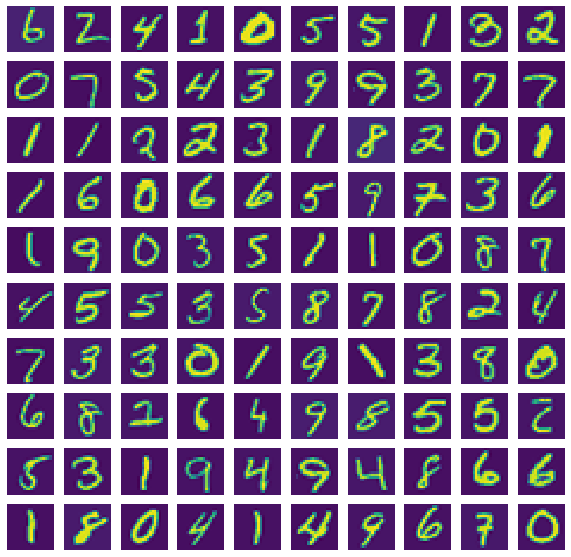

In [3]:
# visualizando os dados
_, axarr = plt.subplots(10, 10, figsize = (10,10))

for i in range(10):
    for j in range(10):
        # reordena a matriz para 20x20 usando o estilo de indexação do Fortran
        axarr[i,j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order = "F"))      
        # remove os eixos cartesianos de cada subplotagem
        axarr[i,j].axis('off')

### 1.2 Representação do Modelo

A rede neural terá 3 camadas ao total:

- Uma cada de entrada;
- Uma cadas oculta;
- Uma camada de saída;

![neural-network-model](Imagens/neural-network-model.PNG)

Lembre-se de que as entradas serão imagens em escala de cinza 20 x 20 “desenroladas” para formar 400 recursos de entrada de alimentação para a rede neural. Portanto, nossa camada de entrada tem 400 neurônios. Além disso, a camada oculta tem 25 neurônios e a camada de saída 10 neurônios correspondendo a 10 dígitos (ou classes) que nosso modelo prevê. O +1 na figura acima representa o bias.

## O bias novamente nas redes neurais

> O bias aumenta o grau de liberdade dos ajustes dos pesos.

![bias-effect](Imagens/bias-effect.png)

## Como determinar o número de camadas?

O número de neurônios em cada camada é uma questão mais empírica, não existindo regras explícitas para um cálculo ideal. Jeff Heaton, o autor de **Introduction to Neural Networks for Java**, sugere três abordagens iniciais:

- O número de neurônios escondidos deve estar entre o tamanho da camada de entrada e o da camada de saída.
- O número de neurônios escondidos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída.
- O número de neurônios escondidos deve ser menor que o dobro do tamanho da camada de entrada. 

Recebemos um conjunto de parâmetros de rede já treinados. Eles são armazenados em **ex4weights.mat** e serão carregados em teta1 e teta2 adicionados a um outro só vetor. 

- 400 unidades na camada de entrada;
- 25 unidades na camada oculta;  
- 10 unidades na camada de saída;

In [4]:
# carrega os parâmetros treinados vinculados ao exercício
pesos = loadmat('dataset/ex4weights.mat')
teta1 = pesos['Theta1']    # teta1 tem uma dimensão de 25 x 401
teta2 = pesos['Theta2']    #teta2 tem uma dimensão de 10 x 26

# ravel = torna teta1 e teta2 unidimensionais
parametros_totais = np.hstack((teta1.ravel(order='F'), teta2.ravel(order='F')))  

# hiperparâmetros da rede neural
dim_camada_entrada = 400
dim_camada_oculta = 25
num_classes = 10
lmbda = 1

In [5]:
# visualizando a dimensão do vetor de parâmetros
parametros_totais.shape

(10285,)

### 1.3 Forwardpropagation e Função de Custo

Primeiro, será implementado a função de custo seguida de gradiente para a rede neural (para a qual usamos o algoritmo de retropropagação).

- A função de custo para a rede neural com regularização é

![cost-function-regular](Imagens/cost-function-regular.PNG)

#### Função sigmoide

In [6]:
def sigmoide(x):
    '''
    Função de ativação sigmoide
    '''
    return 1 / (1 + np.exp(-x))

Além disso, enquanto os rótulos originais (na variável y) eram 1, 2, ..., 10, com o propósito de treinar uma rede neural, precisamos recodificar os rótulos como vetores contendo apenas valores 0 ou 1, de modo que

![one-hot-encoder](Imagens/one-hot-encoder.PNG)

In [7]:
# manipulando a saída das classes usando o one hot encoder
(pd.get_dummies(y.flatten()))

,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,1,0
4996,0,0,0,0,0,0,0,0,1,0
4997,0,0,0,0,0,0,0,0,1,0
4998,0,0,0,0,0,0,0,0,1,0


#### Função de custo

In [8]:
def funcaoCusto(parametros_totais, dim_entrada, dim_oculta, num_classes, X, y, lmbda):
    '''
    Função que computa a função de custo da rede neural regularizada
    '''
    # separa os parâmetros associados a camada oculta e a camada de saída
    teta1 = np.reshape(parametros_totais[:dim_oculta * (dim_entrada + 1)], (dim_oculta, dim_entrada + 1), 'F')
    teta2 = np.reshape(parametros_totais[dim_oculta * (dim_entrada + 1):], (num_classes, dim_oculta + 1), 'F')

    '''
    algoritmo de Forwardpropagation 
    '''
    # m exemplos treináveis
    m = len(y)
    # cria um vetor coluna de bias m x 1
    ones = np.ones((m, 1))
    # adicionando o bias na camada de entrada
    a1 = np.hstack((ones, X))
    # ativação dos neurônios da camada oculta
    a2 = sigmoide(a1.dot(teta1.T))
    # adicionando o bias na camada oculta
    a2 = np.hstack((ones, a2))
    # ativção dos neurônios da camada de saída
    h = sigmoide(a2.dot(teta2.T))
    
    # manipulando a saída das classes usando o one hot encoder
    y_d = pd.get_dummies(y.flatten())
    
    # seprando em partes a função de custo
    parte1 = np.multiply(y_d, np.log(h))
    parte2 = np.multiply(1-y_d, np.log(1-h))
    parte3 = np.sum(parte1 + parte2)
    
    # separando em partes a expressão de regularização da função de custo
    soma1_regularizada = np.sum(np.sum(np.power(teta1[:,1:],2), axis = 1)) # ignora o neurônio relativo ao bias
    soma2_regularizada = np.sum(np.sum(np.power(teta2[:,1:],2), axis = 1)) # ignora o neurônio relativo ao bias
    
    # junta as partes e retorna a expressão total da função de custo
    return np.sum(parte3 / (-m)) + (soma1_regularizada + soma2_regularizada) * lmbda / (2 * m)

In [9]:
# obtendo o valor da função de custo
funcaoCusto(parametros_totais, dim_camada_entrada, dim_camada_oculta, num_classes, X, y, lmbda)

0.38376985909092354

## Backpropagation

Nesta parte do código, será implementado o algoritmo de retropropagação para calcular os gradientes da rede neural. Depois de calcular o gradiente, será possível realizar o treinamento da rede neural, minimizando a função de custo usando um otimizador avançado como fmincg do scipy.

### Função sigmoide do gradiente

![sigmoid-gradient](Imagens/sigmoid-gradient.PNG)

In [10]:
def sigmoideGradiente(x):
    '''
    Função que calculo o sigmoide do gradiente descente
    '''
    return np.multiply(sigmoide(x), 1 - sigmoide(x))

Quando se realiza um treinamento com redes neurais, é importante inicializar aleatoriamente os parâmetros para que ocorra a **quebra de simetria**. Agora imagine que foi inicializado todos os pesos com o mesmo valor (por exemplo, zero ou um). Nesse caso, cada unidade oculta receberá exatamente o mesmo valor. Por exemplo, se todos os pesos são inicializados em 1, a ativação em cada neurônio da camada posterior vai ser igual a anterior. Se todos os pesos forem zeros, o que é ainda pior, a saída das funções de ativação da camada oculta serão zero. Não importa qual foi a entrada, se todos os pesos forem iguais, todas as unidades na camada oculta também serão as mesmas . Este é o principal problema com a simetria e a razão pela qual você deve inicializar pesos aleatoriamente (ou, pelo menos, com valores diferentes).

![random-initialization](Imagens/random-initialization.PNG)

In [11]:
def inicia_pesos_randomicos(dim_entrada, dim_saida):
    '''
    Função que inicializa os pesos da rede neural de forma randômica
    '''
    # sugestão dada no curso para um epsilon ideal
    epsilon = 0.12
    return np.random.rand(dim_saida, dim_entrada + 1) * 2 * epsilon - epsilon

In [12]:
# definindo os parâmetros randômicos da camada oculta e camada de saída
teta1_inicial = inicia_pesos_randomicos(dim_camada_entrada, dim_camada_oculta)
teta2_inicial = inicia_pesos_randomicos(dim_camada_oculta, num_classes)

# adicionando os parâmetros em um único vetor unidimensional
parametros_rand_iniciais = np.hstack((teta1_inicial.ravel(order = 'F'), teta2_inicial.ravel(order = 'F')))

### Implementação do algoritmo de Backpropagation

![backpropagation-algorithm](Imagens/backpropagation-algorithm.PNG)

1. **Calcule o algoritmo Forwardpropagation para obter a ativação de saída a3;**
2. **Calcule o termo de erro d3 obtido subtraindo a saída real de nossa saída calculada a3;**
3. **Para a camada oculta, o termo de erro d2 pode ser calculado como abaixo:**

![error-term](Imagens/error-term.PNG)

4. **Acumule os gradientes em delta1 e delta2;**
5. **Obtenha os gradientes da rede neural dividindo os gradientes da etapa 4 por m;**
6. **Adicione os termos de regularização aos gradientes;**

In [13]:
def backpropagation_gradiente(parametros_totais, dim_entrada, dim_oculta, num_classes, X, y, lmbda):
    '''
    função que realiza o gradiente descendente através do algoritmo de Backpropagation
    '''
    # separa os parâmetros associados a camada oculta e a camada de saída
    teta1 = np.reshape(parametros_totais[:dim_oculta * (dim_entrada + 1)], (dim_oculta, dim_entrada + 1), 'F')
    teta2 = np.reshape(parametros_totais[dim_oculta * (dim_entrada + 1):], (num_classes, dim_oculta + 1), 'F')
    
    # manipulando a saída das classes usando o one hot encoder
    y_d = pd.get_dummies(y.flatten())
    
    # definindo os arrays delta que indicam o erro associado a cada um dos parâmetros (o objetivo é minimizá-los)
    delta1 = np.zeros(teta1.shape)
    delta2 = np.zeros(teta2.shape)

    # m exemplos treináveis
    m = len(y)
    
    for i in range(X.shape[0]):
        '''
        Forwardpropagation
        '''
        # cria um vetor coluna de bias m x 1
        ones = np.ones(1)
        # adicionando o bias na camada de entrada
        a1 = np.hstack((ones, X[i]))
        # produto escalar da saída dos neurônios da primeira camada com os parâmetros associados a camada oculta
        z2 = a1.dot(teta1.T)
        # ativação dos neurônios da camada oculta
        a2 = np.hstack((ones, sigmoide(z2)))
        # produto escalar da saída dos neurônios da camada oculta com os parâmetros associados a camade de saída
        z3 = a2.dot(teta2.T)
        # ativação dos neurônios da camada de saída
        a3 = sigmoide(z3)
        '''
        Backpropagation
        '''
        # calcula o erro associado aos parâmetros da camada de saída
        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        # adicionando o bias na camada oculta
        z2 = np.hstack((ones, z2))
        # calcula o erro associado aos parâmetros da camada oculta
        d2 = np.multiply(teta2.T.dot(d3.T), sigmoideGradiente(z2).T[:,np.newaxis])
        # computa o algoritmo do gradiente descendente para atualização dos pesos na camada oculta e na camada de saída
        delta1 = delta1 + d2[1:,:].dot(a1[np.newaxis,:])
        delta2 = delta2 + d3.T.dot(a2[np.newaxis,:])
    
    # divide pelos m exemplos treináveis para terminar de computar a fórmula
    delta1 /= m
    delta2 /= m
    
    # computa as derivadas para a função de custo
    delta1[:,1:] = delta1[:,1:] + teta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + teta2[:,1:] * lmbda / m
    
    # retorna o vetor unidimensional com todos os parâmetros
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [14]:
# recebendo os parâmetros atualizados por backpropagation
parametros_backpropagation = backpropagation_gradiente(parametros_rand_iniciais, dim_camada_entrada, dim_camada_oculta, num_classes, 
                                                       X, y, lmbda)

### Checando o gradiente

Para verificar se o algoritmo de backpropagation está funcionando bem, temos a seguinte expressão obtida através de métodos numéricos:

![gradient-checking](Imagens/gradient-checking.PNG)

In [15]:
def checaGradiente(parametros_iniciais, parametros_backpropagation, dim_entrada, dim_oculta, num_classes, X, y, lmbda = 0.0):
    # utilizando o valor de epsilon ideal mostrado no curso
    epsilon = 0.0001
    
    # recebe os vetores unidimensionais com os parâmetros
    univetor_numerico = parametros_iniciais
    univetor_backprop = parametros_backpropagation
    
    # recebe os elementos do vetor
    num_elementos = len(univetor_numerico) 
    
    # pega 10 elementos randômicos, calcula o gradiente pelo método numérico, e compara com o obtido através do algoritmo Backpropagation
    for i in range(10):
        x = int(np.random.rand() * num_elementos)
        vetor_epsilon = np.zeros((num_elementos, 1))
        vetor_epsilon[x] = epsilon
        
        # implementa o gradiente pelo método numérico
        cost_high = funcaoCusto(univetor_numerico + vetor_epsilon.flatten(), dim_entrada, dim_oculta, num_classes, X, y, lmbda)
        cost_low  = funcaoCusto(univetor_numerico - vetor_epsilon.flatten(), dim_entrada, dim_oculta, num_classes, X, y, lmbda)
        mygrad = (cost_high - cost_low) / float(2 * epsilon)
        print("Elemento: {0}. Método Numérico = {1:.9f}. BackPropagation = {2:.9f}.".format(x, mygrad, univetor_backprop[x]))
    return None

In [16]:
# verificando se as derivadas realizadas pelo algoritmo backpropagation são equivalentes as do método numérico 
checaGradiente(parametros_rand_iniciais, parametros_backpropagation, dim_camada_entrada, dim_camada_oculta, num_classes, X, y, lmbda)

Elemento: 8356. Método Numérico = 0.002280896. BackPropagation = 0.002280896.
Elemento: 6332. Método Numérico = -0.005432517. BackPropagation = -0.005432517.
Elemento: 9383. Método Numérico = 0.000000515. BackPropagation = 0.000000515.
Elemento: 5789. Método Numérico = 0.008656203. BackPropagation = 0.008656203.
Elemento: 4748. Método Numérico = 0.004289618. BackPropagation = 0.004289618.
Elemento: 3142. Método Numérico = 0.005954569. BackPropagation = 0.005954569.
Elemento: 2931. Método Numérico = 0.006489929. BackPropagation = 0.006489929.
Elemento: 4763. Método Numérico = 0.000432680. BackPropagation = 0.000432680.
Elemento: 6467. Método Numérico = 0.003332279. BackPropagation = 0.003332279.
Elemento: 3528. Método Numérico = 0.000018545. BackPropagation = 0.000018545.


### Treinando o algoritmo com um otimizador

In [17]:
# implementando as funções feitas no otimizado do scipy
teta_otimizado = opt.fmin_cg(maxiter = 50, f = funcaoCusto, x0 = parametros_rand_iniciais, fprime = backpropagation_gradiente,
                             args = (dim_camada_entrada, dim_camada_oculta, num_classes, X, y.flatten(), lmbda))

         Current function value: 0.478300
         Iterations: 50
         Function evaluations: 110
         Gradient evaluations: 110


In [18]:
# obtendo o valor da função de custo para os parâmetros otimizados
funcaoCusto(teta_otimizado, dim_camada_entrada, dim_camada_oculta, num_classes, X, y, lmbda)

0.4782996246083039

In [19]:
teta1_otimizado = np.reshape(teta_otimizado[:dim_camada_oculta * (dim_camada_entrada + 1)], 
                             (dim_camada_oculta, dim_camada_entrada + 1), 'F')
teta2_otimizado = np.reshape(teta_otimizado[dim_camada_oculta * (dim_camada_entrada + 1):], 
                             (num_classes, dim_camada_oculta + 1), 'F')

### Realizando a predição do algoritmo

In [20]:
def predicao(teta1, teta2, X, y):
    '''
    Função responsável por realizar a previsão do algoritmo
    '''
    # implementando o algoritmo feedforward com os parâmetros ajustados
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoide(a1.dot(teta1.T))
    a2 = np.hstack((ones, a2))
    # obtendo a hipótese do algoritmo (o ideal seria a hipótese ser equivalente aos resultados das classes y)
    h = sigmoide(a2.dot(teta2.T))
    # sabendo que foi aplicado o one hot enconder, função retorna o indice da hipotese em que o 1 é ativado
    # soma + 1 pelo fato dos dados começarem em 1, sendo 10 a classe 0
    return np.argmax(h, axis = 1) + 1

In [21]:
# obtém a previsão para cada um dos exemplos do dataset
p = predicao(teta1_otimizado, teta2_otimizado, X, y)
# visualiza a predição do algoritmo
print('Predição: ', np.mean(p == y.flatten()) * 100)

Predição:  96.38
